In [ ]:
import matplotlib.pyplot as plt

# 10가지 클래스를 갖는 이미지 데이터셋
from torchvision.datasets.cifar import CIFAR10 
from torchvision.transforms import ToTensor

In [ ]:
# 데이터셋 불러오기
training_data = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = CIFAR10(
    root='./',
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
!ls # 리눅스 명령어 -> 파일들 뭐있는 보여줌

cifar-10-batches-py  cifar-10-python.tar.gz  sample_data


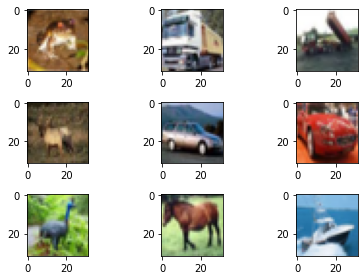

In [ ]:
# 샘플 데이터 보기
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(training_data.data[i])

plt.tight_layout()
plt.show()

# 이미지 데이터 전처리

## 데이터 증강 : 이미지에 여러 변형을 주어서 이미지 개수를 늘리는 방법
- 회전, 크기 변경, 밀림, 반사, 이동
- 오버피팅 방지를 위해서 -> 이미지에 변화를 줘서 데이터 갯수를 늘리는 것

In [ ]:
#@title 크롭핑 (Cropping)
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

In [ ]:
transforms = Compose([ # 어떤 순서대로 이미지처리를 할 것인가?
    T.ToPILImage(),
    RandomCrop((32, 32), padding=4), # 랜덤으로 이미지를 일부 제거 하고 패딩
    RandomHorizontalFlip(p=0.5), # y축으로 기준으로 대칭
])

Files already downloaded and verified
Files already downloaded and verified


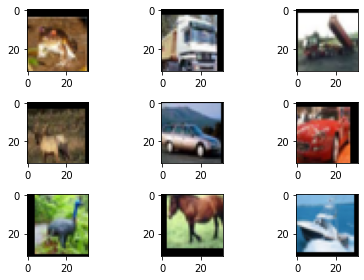

In [ ]:
training_data = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=transforms
)
test_data = CIFAR10(
    root='./',
    train=False,
    download=True,
    transform=transforms
)

# 샘플 데이터 보기
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(transforms(training_data.data[i]))

plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified


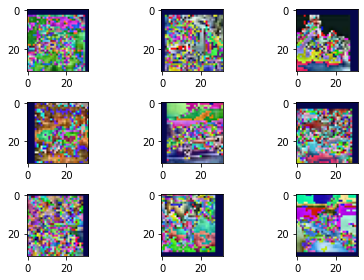

In [ ]:
#@title 이미지 정규화
from torchvision.transforms import Normalize

transforms = Compose(
    [
        T.ToPILImage(),
        RandomCrop((32, 32), padding=4), # 랜덤으로 이미지를 일부 제거 하고 패딩
        RandomHorizontalFlip(p=0.5), # y축으로 기준으로 대칭
        T.ToTensor(),
        # 정규화 - mean (평균값) / std (표준편차) 
        # R(빨강), G(초록), B(파랑)
        Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
        T.ToPILImage(),
    ]
)

training_data = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=transforms
)

test_data = CIFAR10(
    root='./',
    train=False,
    download=True,
    transform=transforms
)

# 샘플 데이터 보기
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(transforms(training_data.data[i]))

plt.tight_layout()
plt.show()

In [ ]:
import torch

# 이미지 데이터셋의 평균과 표준편차
training_data = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=ToTensor()
)

# 0 : 이미지 / 1 : 분류에서 정답 (레이블)
imgs = [item[0] for item in training_data] # 이미지 -> R.G.B 색상의 겹쳐져있음
imgs = torch.stack(imgs, dim=0).numpy() # 파이토치가 받아들일 수 있는 형태(3.H.W)로 전환

Files already downloaded and verified


In [ ]:
imgs1 = [item[0] for item in training_data]
print(len(imgs1))
# 텐서는 요소의 모양을 중요하게 생각하기 때문에 텐서 안에 들어 있는 모든 요소의 모양이 동일해야만 함
# torch.stack() -> (3, H, W) 요소의 모양을 고려하여 합치기
imgs2 = torch.stack(imgs1, dim=0).numpy()
# RGB, H(세로), W(가로)
imgs2.shape

50000


(50000, 3, 32, 32)

In [ ]:
mean_r = imgs[:,0,:,:].mean() # 색상값 -> 평균 (mean)
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r, mean_g, mean_b)

0.49139968 0.48215827 0.44653124


In [ ]:
std_r = imgs[:,0,:,:].std() # 표준편차 -> std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r, std_g, std_b)

0.24703233 0.24348505 0.26158768


## 이미지 정규화
- 이미지는 R, G, B 데이터로 구성
- 어떤 물체를 나타내느냐에 따라 값이 편향
- 데이터의 분포가 너무 치우쳐 있으면 학습에 안 좋은 영향 
→ 따라서 학습하기 전 이런 편향을 계산해 최대한 정규분포를 따르게 하는 것이 좋음 (색이 갖는 분포가 일정하게 처리)
⇒ 이 과정이 **정규화**


# 모델 정의

**nn.Sequential** -> 클래스 : 순서대로 층을 쌓아서 모델 구축 -> 커스터마이징 X
`간단한 신경망 구축`

**nn.Module** : `복잡한 신경망`. 특징을 추출, 여러 가지 층을 추가.

학습 루프

기본 블록
입력 -> 합성곱 3x3 -> ReLU -> 합성곱 3x3 -> ReLU -> 맥스풀링(최댓값) -> 출력

In [ ]:
# VGG 기본 블록 정의
import torch
import torch.nn as nn

In [ ]:
class Dog:
    def __init__(self):
        print('주인님 반갑다 멍!')

Dog()

주인님 반갑다 멍!


In [ ]:
class Person:
    def __init__(self, name):
        print(f"안녕하세요 저는 {name}입니다")

Person('김강사')

안녕하세요 저는 김강사입니다


In [ ]:
class Teacher(Person): # 상속
    def __init__(self, name, subject):
        super(Teacher, self).__init__(name)
        print(f"저는 {subject}을(를) 가르칩니다")

Teacher(name='박강사', subject='코딩')

안녕하세요 저는 박강사입니다
저는 코딩을(를) 가르칩니다


In [ ]:
# Scikit? -> Model. 비슷한 함수, 비슷한 변수들...
# 같은 포맷을 받아서 -> 그 안에 활용
class BasicBlock(nn.Module):
    # 기본 블록 구성하는 기본 정의
    def __init__(self, in_channels, out_channels, hidden_dim):
        # nn.Module
        super(BasicBlock, self).__init__()
        # 합성곱 층
        # in_channels : 입력 채널 수
        # out_channels : 출력 채널 수
        # hidden_dim : 은닉층 채널(차원) 수
        # kernel_size : 커널의 크기
        # padding : 이미지 외곽을 둘러쌀 0의 개수
        # * * * <-  a x a   0 0 0 0 0
        # * * *             0 * * * 0
        # * * *             0 ......0
        self.conv1 = nn.Conv2d(in_channels, hidden_dim,
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels,
                               kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        # 커널의 이동 거리 stride
        # 2 * 2 <= 합성곱으로 처리된 값 [4칸] -> 최댓값
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # 순전파 정의
    def forward(self, x):
        x = self.conv1(x) # 합성곱1을 지나고
        x = self.relu(x) # 활성화함수를 지나고
        x = self.conv2(x) # 합성곱2를 지나고
        x = self.relu(x) # 활성화함수
        x = self.pool(x) # 맥스풀링을 지난걸
        return x # 리턴

## 최대 풀링 (Max Pooling)
* 이미지 크기를 절반으로 줄이는 연산
* 합성곱을 통해 얻은 특징의 위치 정보를 의도적으로 없애 오버피팅을 피하는 기법
* 커널을 이동하면서 커널 안의 최댓값만을 남기는 것 → 중요한 특징의 값을 알 수 있음 (but 그 값의 위치는 알수 X)

In [ ]:
#@title CNN 모델
class CNN(nn.Module):
    def __init__(self, num_classes): # 클래스 개수
        super(CNN, self).__init__()

        # 합성곱 기본 블록 정의
        # R, G, B. => h, w (화소별) 입력층/출력층 
        # 32 x 32 -> 16.
        self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
        self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
        self.block3 = BasicBlock(in_channels=128, out_channels=256, hidden_dim=128)
        
        # 분류기
        self.fc1 = nn.Linear(in_features=4096, out_features=2048) # 데이터 손실 (4096->10)
        self.fc2 = nn.Linear(in_features=2048, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes) # 10

        # 분류기의 활성화 함수
        self.relu = nn.ReLU()

    def forward(self, x): # 순전파를 했을 때 작동할 프로그램/기능
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x) # 출력 모양 (-1, 256, 4, 4)
        x = torch.flatten(x, start_dim=1)# 256 * 4 * 4 = 4096
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)

        return x

In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

transforms = Compose([
    RandomCrop((32, 32), padding=4), # 랜덤 크롭핑
    RandomHorizontalFlip(p=0.5), # 1/2 확률로 y축 뒤집기
    ToTensor(), # 텐서 변환
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

In [ ]:
# 학습용/평가용 데이터 불러오기
training_data = CIFAR10(root='./', train=True, download=True, transform=transforms)
test_data = CIFAR10(root='./', train=False, download=True, transform=transforms)

# 데이터로더 정의 (batch size)
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# device? GPU(cuda)? CPU?
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CNN 모델 정의 (<= CNN 클래스 불러오기 -> 객체)
model = CNN(num_classes=10)

# 모델을 device
model.to(device)

Files already downloaded and verified
Files already downloaded and verified


CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

In [ ]:
lr = 1e-3 # 학습률 정의

# 최적화 기법 정의 (adam)
optim = Adam(model.parameters(), lr=lr)

# 학습 루프 정의
for epoch in range(100):
    for data, label in train_loader: # 데이터 호출
        optim.zero_grad() # 기울기 초기화
        preds = model(data.to(device))
        # 분류 문제 (회귀 문제면 MSE)
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward() # 오차 역전파
        optim.step() # 최적화
    
    if epoch==0 or epoch%10==9:
        print(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "CIFAR.pth")

epoch1 loss:0.978824257850647
epoch10 loss:2.08598256111145
epoch20 loss:1.9426709413528442
epoch30 loss:0.9583635926246643
epoch40 loss:0.6207420229911804
epoch50 loss:1.2239677906036377
epoch60 loss:2.3096678256988525
epoch70 loss:2.3022491931915283
epoch80 loss:2.3021397590637207
epoch90 loss:2.300042152404785
epoch100 loss:2.300920009613037


In [ ]:
model.load_state_dict(torch.load('CIFAR.pth', map_location=device))

num_corr = 0

with torch.no_grad():
    for data, label in test_loader:
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr
    
    print(f"Accuracy : {num_corr/len(test_data)}")

Accuracy : 0.1


In [ ]:
# 전이 학습 모델 VGG로 분류하기
# ImageNet : 1천개 사물에 대한 특징을 추출하도록 학습
# -> 사전 학습 -> 우리 데이터 넣어서 -> 10개의 학습을 하도록 줄여서 -> 모델링
from torchvision.models.vgg import vgg16

In [ ]:
model = vgg16(pretrained=True)
# 분류기 <- vgg16 이미 학습된 데이터를 통해 만들어진 모델
# 10개를 분류 <- 커스터마이징
# 분류기만 우리한테 맞도록
fc = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(),
    nn.Dropout(), # 오버피팅 <- 몇몇 결과값(뉴런)을 의도적으로 0으로 바꿔서 학습
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 10),
)

model.classifier = fc
model.to(device)

In [ ]:
# 데이터 전처리, 증강 
# 데이터 로더 정의
# 학습루프 정의
# 모델 성능 평가

from torchvision.transforms import Resize

transforms = Compose([
    # 전이학습한 모델 224
    Resize(224),
    RandomCrop((224, 224), padding=4), # 랜덤 크롭핑
    RandomHorizontalFlip(p=0.5), # 1/2 확률로 y축 뒤집기
    ToTensor(), # 텐서 변환
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

# 학습용/평가용 데이터 불러오기
training_data = CIFAR10(root='./', train=True, download=True, transform=transforms)
test_data = CIFAR10(root='./', train=False, download=True, transform=transforms)

# 데이터로더 정의 (batch size)
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

lr = 1e-4 # 학습률 정의

# 최적화 기법 정의 (adam)
optim = Adam(model.parameters(), lr=lr)

import tqdm

# 학습 루프 정의
for epoch in range(30):
    iterator = tqdm.tqdm(train_loader)
    for data, label in iterator: # 데이터 호출
        optim.zero_grad() # 기울기 초기화
        preds = model(data.to(device))
        # 분류 문제 (회귀 문제면 MSE)
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward() # 오차 역전파
        optim.step() # 최적화
    
    if epoch==0 or epoch%10==9:
        print(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "CIFAR_pretrained.pth")

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1563/1563 [02:06<00:00, 12.33it/s]


epoch1 loss:0.12605495750904083


100%|██████████| 1563/1563 [02:05<00:00, 12.44it/s]


epoch10 loss:0.012949091382324696


100%|██████████| 1563/1563 [02:06<00:00, 12.31it/s]


epoch20 loss:0.0006074013072066009


100%|██████████| 1563/1563 [02:06<00:00, 12.38it/s]


epoch30 loss:0.0659649595618248


In [ ]:
model.load_state_dict(torch.load('CIFAR_pretrained.pth', map_location=device))

num_corr = 0

with torch.no_grad():
    for data, label in test_loader:
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr
    
    print(f"Accuracy : {num_corr/len(test_data)}")

Accuracy : 0.9248
